## SARSA (on-policy TD Control) Algorithm

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)
- [University of Alberta's RL specialization](https://www.coursera.org/specializations/reinforcement-learning)

![SARSA](./algo_img/sarsa_on_policy_td_estimation.png "SARSA")

THe SARSA algorithm uses q-values (aka state-action values) instead of state values as used in TD(0) estimation algorithm:

- TD Update:

\begin{align*}
Q(S_t, A_t) \; & = \; Q(S_t, A_t) \, + \, \alpha[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) \, - \, Q(S_t, A_t)] \\
& = \; Q(S_t, A_t) \, + \, \alpha \cdot \delta_t \\
\end{align*}

, where $\; \delta_t \; = \; R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) \, - \, Q(S_t, A_t) \; = \;$ TD error

To carry out an update as per the above equation, we need all the five values $S_t$, $A_t$, $R_{t+1}$,
$S_{t+1}$, and $A_{t+1}$. This is the reason the approach is called SARSA (state, action, reward,
state, action).

Please also note that for all episodic policies, the terminal states have $Q(S, A)$ equal to zero; i.e., once in terminal state, the person cannot transition anywhere and will keep getting a reward of zero. This is another way of saying that the episode ends and $Q(S, A)$ is zero for all terminal states. Therefore, when $S_{t+1}$ is a terminal state, the above equation will have $Q(S_{t+1}, A_{t+1}) \, = \, 0$, and the update equation will look like this:

$$Q(S_t, A_t) \; = \; Q(S_t, A_t) \, + \, \alpha[R_{t+1} \, - \, Q(S_t, A_t)]$$

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [186]:
class SARSA:
    """SARSA (on-policy TD control) algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_Q(self, state, action):
        return self._Q[state][action]


    def set_Q(self, state, action, value):
        self._Q[state][action] = value


    def update(self, state, action, reward, next_state, next_action, done):
        """
        This is the main update function for the SARSA algorithm.
        Note that this function only contains the update equations, 
        not the entire SARSA algorithm.
        """
        if not done:
            td_error = reward + \
                       self.gamma * self._get_Q(next_state, next_action) - \
                       self._get_Q(state, action)
        else:
            td_error = reward - self._get_Q(state, action)
        q_value = self._get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, q_value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state-action pair that has the highest Q-value.
        If there are multiple actions with the same Q-value,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self._get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [187]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [188]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: SARSA object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(t_max):
            next_state, reward, done, trunc, _ = env.step(action)
            next_action = agent.get_action(next_state)
            flag = (done or trunc)
            agent.update(state, action, reward, next_state, next_action, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)


In [189]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out SARSA on Cliff Walking environment

In [190]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [191]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [192]:
cw_env.reset()

(36, {'prob': 1})

In [193]:
cw_env.action_space.n

4

In [194]:
cw_env.observation_space.n

48

In [197]:
agent1 = SARSA(
    get_possible_actions = lambda s : range(cw_env.action_space.n),
    strategy = epsilon_greedy_strategy,
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(cw_env, agent1, num_episodes=5000, decay_rate=0.99)

100%|██████████| 5000/5000 [00:10<00:00, 476.47it/s]


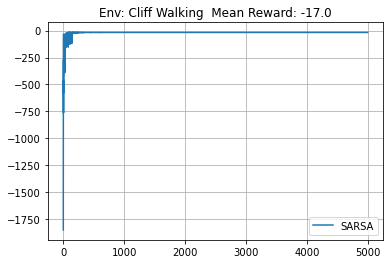

In [198]:
plot_rewards("Cliff Walking", rewards, "SARSA")

### Trying out SARSA on Taxi environment

In [33]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [199]:
t_env = gym.make("Taxi-v3")

In [200]:
t_env.reset()

(409, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 1, 0], dtype=int8)})

In [201]:
t_env.action_space.n

6

In [202]:
t_env.observation_space.n

500

In [205]:
agent2 = SARSA(
    get_possible_actions = lambda state: range(t_env.action_space.n),
    strategy = epsilon_greedy_strategy, 
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(t_env, agent2, num_episodes=5000, decay_rate=0.99)

100%|██████████| 5000/5000 [00:14<00:00, 335.66it/s]


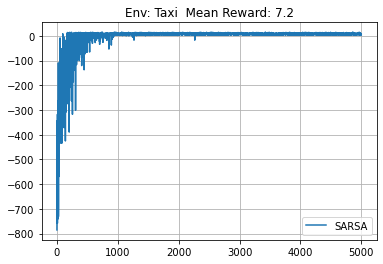

In [206]:
plot_rewards("Taxi", rewards, "SARSA")